In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
from PIL import Image
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.applications import VGG19, ResNet50V2, ResNet101V2, InceptionResNetV2, NASNetLarge, InceptionV3

### Loading in presetup files downloaded from https://ai.stanford.edu/~jkrause/cars/car_dataset.html

In [2]:
meta = scipy.io.loadmat('devkit/cars_meta.mat')
train = scipy.io.loadmat('devkit/cars_train_annos.mat')
test = scipy.io.loadmat('devkit/cars_test_annos_withlabels.mat')

In [3]:
classes = pd.DataFrame(meta['class_names'][0], columns=['title'])

classes['title']
classes_list = []
for value in classes['title']:
    value = value[0]
    classes_list.append(value)
    
classes['title'] = classes_list

In [4]:
classes['title'].head()

0    AM General Hummer SUV 2000
1           Acura RL Sedan 2012
2           Acura TL Sedan 2012
3          Acura TL Type-S 2008
4          Acura TSX Sedan 2012
Name: title, dtype: object

### Creating a function to get the image bounds, labels, and file names for both training and testing sets

In [5]:
def get_bounds_and_labels(dataset):
    dataset_file_name_list = []
    dataset_image_bounds = []
    dataset_label_name_list = []

    for i in range(dataset['annotations'].shape[1]):
        dataset_file_name_list.append(dataset['annotations'][:,i][0][5][0])
        dataset_label_name_list.append(dataset['annotations'][:,i][0][4][0][0]) 
        
        bounds_list = []
        for j in range(4):
            bounds_list.append(dataset['annotations'][:,i][0][j][0][0])
        dataset_image_bounds.append(bounds_list)
        #returns 3 variables to be unpacked 
    return dataset_file_name_list, dataset_label_name_list, dataset_image_bounds

### Running function on both training and testing data 

In [6]:
test_files, test_labels, test_bounds = get_bounds_and_labels(test)
train_files, train_labels, train_bounds = get_bounds_and_labels(train)

### Displaying partial output for training set variables

In [7]:
train_files[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

In [8]:
train_labels[:5]

[14, 3, 91, 134, 106]

In [9]:
train_bounds[:5]

[[39, 116, 569, 375],
 [36, 116, 868, 587],
 [85, 109, 601, 381],
 [621, 393, 1484, 1096],
 [14, 36, 133, 99]]

### Displaying partial output for testing set variables

In [10]:
test_files[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

In [11]:
test_labels[:5]

[181, 103, 145, 187, 185]

In [12]:
test_bounds[:5]

[[30, 52, 246, 147],
 [100, 19, 576, 203],
 [51, 105, 968, 659],
 [67, 84, 581, 407],
 [140, 151, 593, 339]]

### Creating function to set up dataframe for Image Data Generator

In [13]:
def create_file_dataframe():
    
    #creating list of file names from directory
    train_list_files = []
    for file in os.listdir('cars_train/'):
        train_list_files.append(file)
    
    #creating dataframe
    df = pd.DataFrame(train_list_files, columns=['files'])
    
    new_labels = train_labels + test_labels

    df['label'] = new_labels
    df['label'] = df['label'].apply(lambda x: str(x).split(' '))
    
    return df

In [14]:
df = create_file_dataframe()
df

,files,label
0,00001.jpg,[14]
1,00002.jpg,[3]
2,00003.jpg,[91]
3,00004.jpg,[134]
4,00005.jpg,[106]
...,...,...
16180,test_08037.jpg,[63]
16181,test_08038.jpg,[16]
16182,test_08039.jpg,[17]
16183,test_08040.jpg,[38]


### Using TensorFlow's Image Data Generator to create matrices interpretable by the neural network

In [15]:
train_data_generator = ImageDataGenerator(rescale=1./255., validation_split=.1)
test_data_generator = ImageDataGenerator(rescale=1./255.)

In [16]:
training = train_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='cars_train/',
    x_col='files',
    y_col='label',
    subset="training",
    seed=42,
    shuffle=True,
    rotation_range=180,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical")


validation = train_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='cars_train/',
    x_col='files',
    y_col='label',
    subset="validation",
    seed=42,
    shuffle=True,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical")

Found 14567 validated image filenames belonging to 196 classes.
Found 1618 validated image filenames belonging to 196 classes.


### Importing EfficientNetB3 Model and setting a portion of the layers to trainable

In [17]:
pre_trained = efn.EfficientNetB0(weights='imagenet', include_top=False, 
                       input_shape=(150, 150, 3))

In [18]:
len(pre_trained.layers)

230

In [19]:
for layer in pre_trained.layers[:50]:
    layer.trainable = False
    
for layer in pre_trained.layers[50:]:
    layer.trainable = True

### Creating the model topology, optimizer, and compiling the model

In [20]:
model = Sequential()

# model.add(efficient)

model.add(Conv2D(filters=32,           
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(150, 150, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64,           
                     kernel_size=(3, 3),
                     activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128,           
                     kernel_size=(3, 3),
                     activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256,           
                     kernel_size=(3, 3),
                     activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(.3))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(196, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, metrics=['accuracy'])

### Displaying model layer summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

### Fitting the model, validating using validation split created above

In [22]:
history = model.fit(training, validation_data=validation, epochs=50, verbose=1, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 228 steps, validate for 26 steps
Epoch 1/50
228/228 [==============================] - 34s 148ms/step - loss: 5.1794 - accuracy: 0.0107 - val_loss: 5.1297 - val_accuracy: 0.0155
Epoch 2/50
228/228 [==============================] - 32s 141ms/step - loss: 5.0349 - accuracy: 0.0207 - val_loss: 4.9586 - val_accuracy: 0.0216
Epoch 3/50
228/228 [==============================] - 32s 139ms/step - loss: 4.6639 - accuracy: 0.0457 - val_loss: 4.4627 - val_accuracy: 0.0606
Epoch 4/50
228/228 [==============================] - 32s 140ms/step - loss: 3.9645 - accuracy: 0.1213 - val_loss: 3.8403 - val_accuracy: 0.1323
Epoch 5/50
228/228 [==============================] - 32s 139ms/step - loss: 3.1842 - accuracy: 0.2351 - val_loss: 3.4914 - val_accuracy: 0.1904
Epoch 6/50
228/228 [==============================] - 32s 139ms/step - loss: 2.4841 - accuracy: 0.3684 - val_loss: 3.1611 - val_accuracy: 0.2621
Epoch 7/50
228/228 [=================

### Plotting accuracy over number of epochs

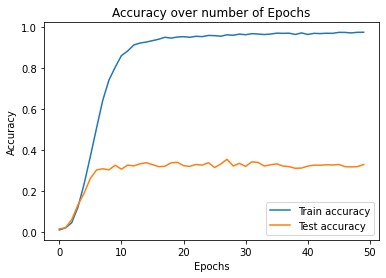

In [23]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over number of Epochs')
plt.legend();

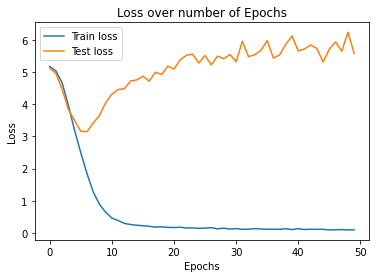

In [24]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of Epochs')
plt.legend();